# Algoritmos Geneticos

Suponga que le piden que haga un mapa de la efectividad de un tiro a la canasta de una cancha de basquetbol, asumiendo que se lanza a la canasta más cercana...

## Optimización

## Implementación de Algoritmos Genéticos

Los algoritmos genéticos, también conocidos simplemente como "GA", son algoritmos inspirados en la teoría de la selección natural de Charles Darwin que tiene como objetivo encontrar soluciones óptimas para problemas de los que no sabemos mucho. Por ejemplo: ¿Cómo encontrar  el máximo o mínimo. de una función, dada si existe mas de un modo, o mas aún  cuando no puede derivarla? El algoritmo esta basado en tres operaciones básicas: selección, reproducción y mutación. Generamos un conjunto aleatorio de individuos, seleccionamos los mejores, los cruzamos y finalmente, mutamos ligeramente el resultado, una y otra vez hasta encontrar una solución aceptable. Veamos cómo escribir una implementación simple de algoritmo.

El primer paso es generar nuestra población inicial. Una población o generación es nuestro conjunto actual de posibles soluciones, llamadas individuos. Iremos iterando durante varias generaciones para mejorarlo hasta que encontremos una solución aceptable. La primera generación se genera aleatoriamente.

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#  Now let's define the hyperbox where our chromosomes will live
#  Nuestros individuos se ajustan aleatoriamente a estos límites
Ns=40               ## Chromosome number
Nx=2                ## Chromosome gene number
EPOCHS=100          ## Generations number which the algorithm will evolve

allele = np.zeros(shape=(Nx,2))
allele[0]=[-10, 0]   ## Limits on gene 0 i.e. the allele
allele[1]=[-6.5,0]   ## Limits on gene 1 i.e. the allele

def createPopulation():

    population = np.zeros(shape=(Ns,Nx))
    for i in range(Ns):
        population[i]= [random.uniform(allele[0,0],allele[0,1]), random.uniform(allele[1,0],allele[1,1])]
    return population

Esta función genera una poblacion de $N_s$ cromosomas los cuales actuarán en la hipercaja definida por $RANGE[j]$ para cada gen $j$, es decir $RANGE[j]$ es el allele del gen $j$. Esto resulta en que nuestros cromosomas se ajustan aleatoriamente a estos límites, donde por cada gen del cromosoma se introduce un nuevo eje a la hipercaja, es decir, la hipercaja es un subespacio vectorial de $\mathbb{R}^{Nx}$.

Sea $p_i$ el cromosoma $[x,y]$, donde $i \in [0..N_s-1]$. Definiremos nuestra función de aptitud (fitness en inglés) $fitness(p_i)$. Esta función será la que evaluará la aptitud del cromosoma $p_i$. En el caso de maximización/minimización a mayor/menor valor devuelto por la función $fitness(p_i)$ más apto será el cromosoma $p_i$. Los cromosomas mas aptos, de acuerdo al  principio de supervivencia de los mejores, deben preservarse y reproducirse mientras que las peores deben ser eliminados. Utilizaremos la función  $f(x,y)=Sin(y)*e^{(1-Cos(x))^2}+Cos(x)*e^{(1-sin(y))^2}+(x-y)^2$ como función de aptitud para encontrar el punto mínimo del la misma i.e. minimizaremos la función. El óptimo de esta función, en el caso de minimización, viene dado por el cromosoma $p^* = [-3.1302468, -1.5821422]$

In [2]:
def F(x,y):
    return np.sin(y)*np.exp((1-np.cos(x))**2)+np.cos(x)*np.exp((1-np.sin(y))**2)+(x-y)**2

In [3]:
def fitness(chromosome):

    return F(chromosome[0], chromosome[1])


Familiarizemonos con $fitnes(chromosoma)$.

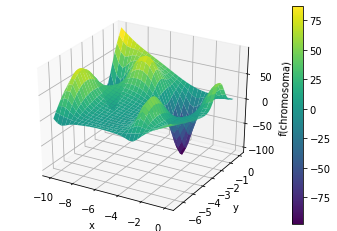

In [ ]:
x = np.linspace(allele[0,0], allele[0,1], 30)
y = np.linspace(allele[1,0], allele[1,1], 30)
X, Y = np.meshgrid(x, y)
Z = F(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
#im=ax.contour3D(X, Y, Z,200, cmap='viridis')
im=ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(chromosoma)');
cmap = plt.cm.viridis
plt.colorbar(im, cmap=cmap)


Como se puede ver es una función multimodal por lo cual si aplicaramos un método basado en gradientes seguramente quedaría atrapado en algún mínimo local, por supuesto que uno de ellos sería el mínimo global pero quien lo aseguraría. Por lo tanto esta es una función que puede perfecta para aplicar el paradigma de algoritmos genéticos. Analizemosla con su gráfica de contorno:

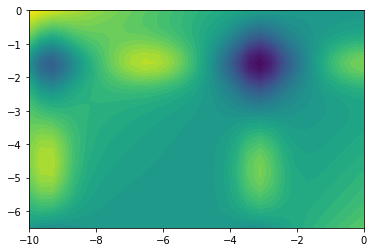

In [ ]:
cp = plt.contourf(X, Y, Z,50)

plt.show()

ax.set_title('Contour Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

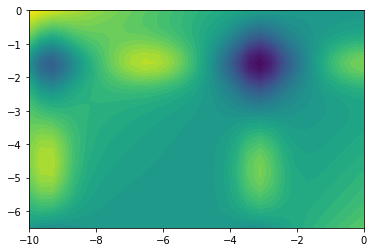

In [ ]:
cp = plt.contourf(X, Y, Z,50)

plt.show()

ax.set_title('Contour Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

Como se puede apreciar, $fitness(x,y)$ contiene varios valles y crestas en el rango que decidimos analizar nuestro problema.

Una vez que hemos definido nuestra función para generar la población y nuestra función de aptitud,, podemos comenzar a reproducir a los cromosomas con los cuales basaremos la próxima generación. Haremos esto hasta que encontremos una solución aceptable. Hay varios criterios de terminación, en nuestro caso nuestro criterio de terminación ser cuando alcanzemos el número de épocas predefinido. Hasta ahora, nuestra función, sin hacer ninguna operación genética, la podemos resumir en el siguiente codigo:

### Selección

El primer paso es seleccionar a los cromosomas que participarán en el proceso de reproducción. Implimentaremos un método que preserva el principio de la supervivencia de los mejores llamado rueda de ruleta el cual divide un ruleta en $N_s$ porciones, donde cada cromosoma tiene una porción que es proporcional a su fitness, y luego girarlo. Este mecanismo asegura que los mejores cromosomas tienen una probabilidad mas alta de ser seleccionadas, mientras que las peores aún tienen una posibilidad, aunque es menor.

Para ilustrar este método, digamos que tenemos seis cromosomas: A, B, C, D, E y F con aptitud 5, 10, 15, 20, 20 y 30 respectivamente. La suma de la aptitud total es de 100, por lo que cada cromosoma $p$ tendrá una probabilidad $\frac{fitness(p)}{fitness_T}$ de ser seleccionado: 5%, 10%, 15%, 20%, 20%, y 30% donde $fitness_T=\sum_{j\in Ns} fitness(p_j)$. 


Seleccionamos un número aleatorio entre 0 y 1 y luego verificamos qué individuo está en la porción seleccionada: $A [0..0.05], B (0.05, 0.15], C (0.15, 0.30], D (0.30, 0.50], D (0.50, 0.70]$ y finalmente $F [0.70, 1.0]$.
Dado que nuestro escenario puede tener un fitness negativo, debemos preprocesar a nuestros cromosomas eligiendo el fitness más bajo, multiplicándolo por -1 y luego agregándolo a todos ellos (por ejemplo, si tenemos dos individuos con estado físico -10 y 5 respectivamente, agregue 10 a ambos convirtiéndose en 0 y 15). También esperamos que el argumento de la población se ordene ascendente por estado físico para que sea más fácil obtener a los peores y mejores individuos.

In [4]:
def computeNormalizedFitnessSum(sortedPopulation, fitnessSum):
    offset = 0
    normalizedFitnessSum = fitnessSum

    lowestFitness = fitness(sortedPopulation[0])
    if lowestFitness < 0:
        offset = -lowestFitness
        normalizedFitnessSum += offset * len(sortedPopulation)
    return normalizedFitnessSum, offset

In [5]:
def rouletteSelection(sortedPopulation, fitnessSum):
    normalizedFitnessSum, offset=computeNormalizedFitnessSum(sortedPopulation, fitnessSum)
    draw = random.uniform(0, 1)
    cumulativeProb = 0
    for chromosome in sortedPopulation:
        probability = (fitness(chromosome) + offset) / normalizedFitnessSum
        cumulativeProb += probability
        if draw <= cumulativeProb:
            #print("Roulete", chromosome)
            return chromosome

Entonces llenemos la próxima generación. Debe tener la misma longitud que la primera, por lo que iteraremos 10 veces seleccionando dos individuos cada uno usando nuestra ruleta y luego cruzándolos. El individuo resultante recibirá una perturbación menor (mutación) para que no nos quedemos en la zona de confort y busquemos soluciones aún mejores que las que tenemos hasta ahora.
Existen varias técnicas de cruce para números reales: por ejemplo, podríamos tomar x del individuo A e y del individuo B, podríamos tomar la media geométrica de cada uno o, la más simple, tomar la media aritmética de cada uno. Si estábamos tratando con datos binarios, la técnica más común es elegir una parte de la cadena de bits de A y una parte de la cadena de bits de B. Por razones de simplicidad, usemos la media aritmética.
Para la mutación también hay muchas opciones: simplemente sumaremos un pequeño número aleatorio entre un intervalo fijo. Este intervalo es la tasa de mutación y puede ajustarse en consecuencia, usemos [-0.05, 0.05]. Para espacios de búsqueda más grandes, puede elegir intervalos más grandes y disminuirlo de generación en generación. Cuando se trata de datos binarios, simplemente puede voltear bits seleccionados al azar de la cadena individual.

### Crossover

El siguiente codigo implementa la operación Crossover. Puedes explicar su implementación_


In [6]:
def crossover(chromosome1, chromosome2):
    return [(chromosome1[0] + chromosome2[0]) / 2, (chromosome1[1] + chromosome2[1]) / 2]

### Mutation

El siguiente codigo implementa la operación mutación (Mutation). Puedes explicar su implementación?


In [7]:
def mutate(chromosome, method=0):
    if method==0:
        #nextX = chromosome[0] + random.uniform(-0.05, 0.05)
        #nextY = chromosome[1] + random.uniform(-0.05, 0.05)
        nextX = chromosome[0] + random.uniform(-5, 5)     #se cambio esto
        nextY = chromosome[1] + random.uniform(-5, 5)
    elif method==1:
        nextX = chromosome[1] 
        nextY = chromosome[0]
    else:
        nextX = random.uniform(allele[0,0], allele[0,1])
        nextY = random.uniform(allele[1,0], allele[1,1])
    # Guarantee we keep inside boundaries
    nextX = min(max(nextX, allele[0,0]), allele[0,1])
    nextY = min(max(nextY, allele[1,0]), allele[1,1])

    return [nextX, nextY]


### Ordenando por fitness la población

El siguiente codigo implementa el ordenamiento de la población. Puedes explicar su implementación?


In [8]:
def sortPopulation(population):
    return np.asarray(sorted(population.tolist(), key=fitness))

### Generando la siguiente generación

El siguiente codigo implementa la imlemantación de la definición de la siguiente generación. Puedes explicar su implementación?


In [9]:
def produceNewChromosomes(population, nGen, elitismo):
    nextGeneration = np.zeros(shape=(Ns,Nx))
    fitnessSum = sum(fitness(chromosome) for chromosome in population)

    #lo agregue yo
    for i in range(0, int(Ns*(1-elitismo))):
      chromosome = rouletteSelection(population, fitnessSum)
      nextGeneration[i]=chromosome
    for i in range(int(Ns*(1-elitismo))+1, Ns):    #cambie el rango
        if random.uniform(0, 1)<Pc[nGen]:
            chromosome1 = rouletteSelection(population, fitnessSum)
            chromosome2 = rouletteSelection(population, fitnessSum)
            chromosome = crossover(chromosome1, chromosome2)
            nextGeneration[i]=chromosome
    for i in range(int(Ns*(1-elitismo))+1 , Ns):   #cambie el rango
        chromosome=population[i]
        if random.uniform(0, 1)<Pm[nGen] and (i<(Ns-1)):
            chromosome = mutate(chromosome,0)
        nextGeneration[i]=chromosome
    return nextGeneration

¡Así que esto es todo! Ahora tenemos los tres pasos de una AG: selección, cruce y mutación. Nuestro método principal es simplemente así:

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plotPopulation(population,nGen):

    x=population[:,0]
    y=population[:,1]
    # Plot
    plt.scatter(x, y,alpha=0.5)
    bestChromosome = population[-1]
    plt.scatter([bestChromosome[0],maximo[0],minimo[0]],[bestChromosome[1],maximo[1],minimo[1]],color=['orange','red','blue'],alpha=0.5)
    plt.title('Generation %d' %nGen)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xmin=allele[0,0],xmax=allele[0,1])
    plt.ylim(bottom=allele[1,0], top=allele[1,1])
    plt.show()
    return

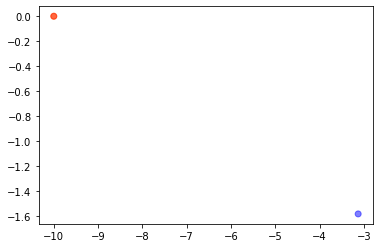


🔬 FINAL RESULT
[-10.   0.] 97.71916710973413


In [14]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pylab as pl
from IPython import display
import matplotlib.cm as cm


#  Nuestros individuos se ajustan aleatoriamente a estos límites
Ns=80              ## Chromosome number
Nx=2                ## Chromosome gene number
EPOCHS=200          ## Generations number which the algorithm will evolve

#  Now let's define the hyperbox where our chromosomes will live
allele = np.zeros(shape=(Nx,2))
allele[0]=[-10, 0]   #￼# Limits on gene 0 i.e. the allele
allele[1]=[-6.5,0]   ## Limits on gene 1 i.e. the allele

Pc=np.linspace(0,.9,EPOCHS)    ## Crossover probability
Pm=np.linspace(0,.3,EPOCHS)    ## Mutation probability

maximo=[-10, 0 ]
minimo=[-3.13024681, -1.5821422 ]

elitismo=.5
population = createPopulation()
for nGen in range(EPOCHS):
    display.display(pl.gcf())
    display.clear_output(wait=True)    
    bestChromosome = population[-1]
    plotPopulation(population, nGen+1)
    nextGeneration=produceNewChromosomes(population,nGen,elitismo)
    #print(nextGeneration)
    population = sortPopulation(nextGeneration)
    #print(population)
    #time.sleep(.01)
input("Presiona Enter para continuar...")
display.display(pl.gcf())
display.clear_output(wait=True)
#plt.contourf(X, Y, Z,50)
#plt.scatter(population[:,0],population[:,0],alpha=0.5)
plt.scatter([bestChromosome[0],maximo[0], minimo[0]],[bestChromosome[1],maximo[1], minimo[1]],color=['orange','red','blue'],alpha=0.5)
#[-3.1302468, -1.5821422]
#ax.set_title('Contour Plot')
#ax.set_xlabel('x (cm)')
#ax.set_ylabel('y (cm)')
plt.show()
print("\n🔬 FINAL RESULT")
print(bestChromosome, fitness(bestChromosome))


La variable bestChromosome mantendrá a nuestro individuo con la mejor forma física después de estas 100 generaciones. Puede ser la solución óptima exacta o no. Si no es este el caso, se tendrán que ajustar sus parámetros (tasa de mutación, generaciones, etc.) y técnicas (métodos de selección, cruce y mutación) hasta que ya no pueda mejorar. La solución final cayo muy cerca de una de los múltiples crestas de la función. Los algoritmos que utilizamos en esta ocasión fueron básicos y con eso quiero decir que realmente no implementamos estrategias muy especializadas en las tres operaciones básicas: Selección (Selection), Cruza(Crossover) y Mutación(Mutation). Sin embargo de aqui podemos partir para la implementación de algoritmos mas sofisticados que encuentren mejores soluciones preferiblemente en menos iteraciones. 